In [ ]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict

import dvu
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
import os.path
import fitz
from tqdm import tqdm
import pathlib
import imodelsx.llm
import json
import requests
import numpy as np
import openai
openai.api_key = open('/home/chansingh/.OPENAI_KEY').read().strip()
plt.style.use('default')
dvu.set_style()

df = pd.read_csv('../data/main_updated.csv')

### Scraping pubmed articles

- E-utilities: https://dataguide.nlm.nih.gov/eutilities/utilities.html
- Metadata: https://www.ncbi.nlm.nih.gov/pmc/tools/get-metadata/
- example paper: https://pubmed.ncbi.nlm.nih.gov/16768059/
- example summary: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id=16768059&retmode=json

In [ ]:
idxs_corrected = df['ref_href_corrected'].notna() # df['ref_href'].isna() & 
df['ref_href'][idxs_corrected] = df['ref_href_corrected'][idxs_corrected]

In [ ]:
def get_metadata(paper_id: str):
    cache_file = f"../data/metadata/{paper_id}.json"
    if os.path.exists(cache_file):
        metadata = json.load(open(cache_file))
    else:
        resp = requests.get(
            f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id={paper_id}&retmode=json"
        )
        metadata = json.loads(resp.text)
        with open(cache_file, "w") as f:
            json.dump(metadata, f, indent=2)
    return metadata


df["ref_metadata"] = np.nan
df["ref_authors"] = np.nan
df["ref_citations"] = np.nan
for i in tqdm(range(df.shape[0])):
    paper_link = df["ref_href"][i]
    if isinstance(paper_link, str) and "pubmed" in paper_link:
        # paper_link = 'https://pubmed.ncbi.nlm.nih.gov/20738765/'
        if paper_link.endswith("/"):
            paper_link = paper_link[:-1]
        paper_id = paper_link.split("/")[-1]
        if not "?" in paper_id and not "&" in paper_id:
            # remove leading zeros
            while paper_id.startswith("0"):
                paper_id = paper_id[1:]

            try:
                metadata = get_metadata(paper_id)
                df["ref_metadata"][i] = metadata
                df["ref_authors"][i] = metadata["result"][paper_id]["authors"]
                df["ref_citations"][i] = metadata["result"][paper_id]["pmcrefcount"]
            except:
                print(f"Error for paper {paper_id}")

(array([12., 31., 19.,  3.,  1.,  1.,  0.,  0.,  0.,  6.]),
 array([  1. ,  17.5,  34. ,  50.5,  67. ,  83.5, 100. , 116.5, 133. ,
        149.5, 166. ]),
 <BarContainer object of 10 artists>)

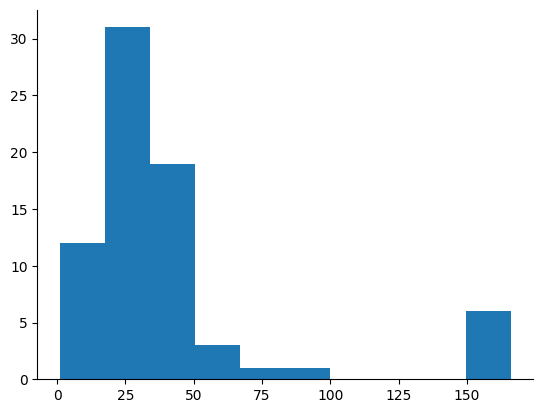

In [5]:
plt.hist(df['ref_citations'].replace('', np.nan).dropna().astype(int))